## Zillow Prize: Zillow’s Home Value Prediction (Zestimate)
### Can you improve the algorithm that changed the world of real estate?

“Zestimates” are estimated home values based on 7.5 million statistical and machine learning models that analyze hundreds of data points on each property. And, by continually improving the median margin of error (from 14% at the onset to 5% today), Zillow has since become established as one of the largest, most trusted marketplaces for real estate information in the U.S. and a leading example of impactful machine learning.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import gc
color = sns.color_palette()
%matplotlib inline

In [3]:
# Read data
train_df = pd.read_csv("./train_2016.csv", parse_dates=["transactiondate"])
train_df.shape

(90811, 3)

In [4]:
train_df.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


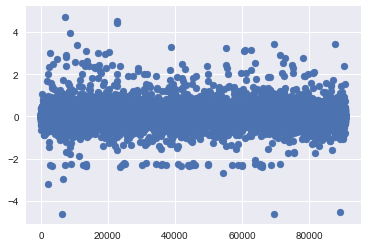

In [5]:
# Explore the logerror distribution
plt.figure()
plt.scatter(range(train_df.shape[0]),train_df['logerror'])
plt.show()

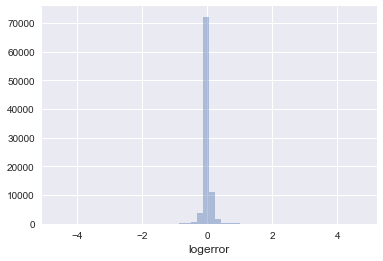

In [6]:
plt.figure()
sns.distplot(train_df.logerror.values, bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()
# There are outliers

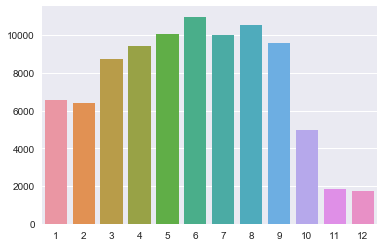

In [20]:
# Explore the transaction date distribution
plt.figure()
train_df['transaction_month'] = train_df['transactiondate'].dt.month
month_hist = train_df['transaction_month'].value_counts()
sns.barplot(month_hist.index, month_hist.values)

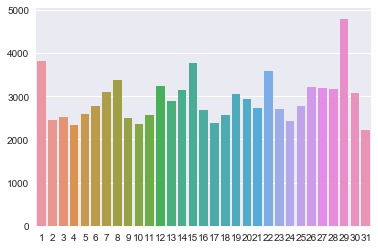

In [21]:
plt.figure()
train_df['transaction_day'] = train_df['transactiondate'].dt.day
day_hist = train_df['transaction_day'].value_counts()
sns.barplot(day_hist.index, day_hist.values)

In [23]:
(train_df['parcelid'].value_counts()).value_counts()
# Most entries have unique parcel ID

1    90554
2      127
3        1
Name: parcelid, dtype: int64

In [6]:
# Explore properties data
prop_df = pd.read_csv("./properties_2016.csv")
prop_df.shape

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2985217, 58)

In [26]:
prop_df.head(2)

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN


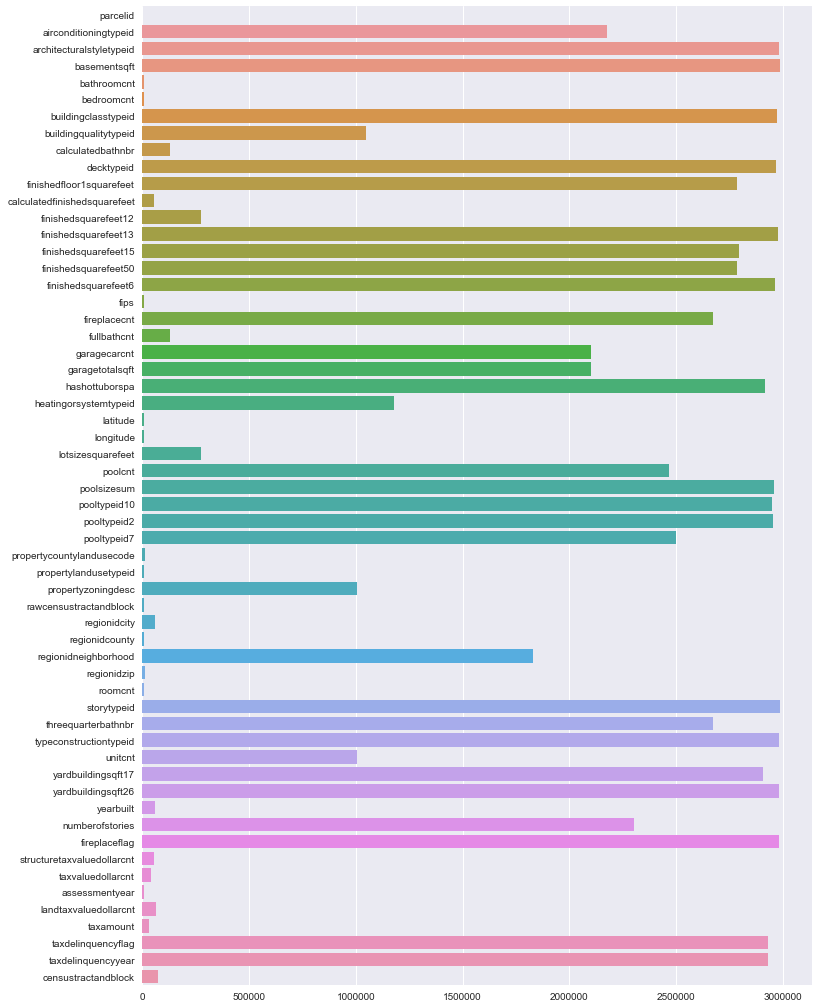

In [31]:
# There seems to be a lot of missing values. Let's take a look how many NaN are in properties data.
prop_null = prop_df.isnull().sum(axis=0)
plt.figure(figsize=(12,18))
sns.barplot(prop_null.values, prop_null.index)
plt.show()

In [7]:
# Combine properties into training data. Merge with same parcel ID
train = pd.merge(train_df, prop_df, on='parcelid', how='left')
train.head(2)

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN


In [9]:
del train_df, prop_df
gc.collect()

634

In [8]:
train.dtypes

parcelid                                 int64
logerror                               float64
transactiondate                 datetime64[ns]
airconditioningtypeid                  float64
architecturalstyletypeid               float64
basementsqft                           float64
bathroomcnt                            float64
bedroomcnt                             float64
buildingclasstypeid                    float64
buildingqualitytypeid                  float64
calculatedbathnbr                      float64
decktypeid                             float64
finishedfloor1squarefeet               float64
calculatedfinishedsquarefeet           float64
finishedsquarefeet12                   float64
finishedsquarefeet13                   float64
finishedsquarefeet15                   float64
finishedsquarefeet50                   float64
finishedsquarefeet6                    float64
fips                                   float64
fireplacecnt                           float64
fullbathcnt  

In [10]:
y_train = train['logerror'].values
# Remove features which are obviously no info
x_train = train.drop(['logerror','transactiondate','parcelid'],axis=1)
del train
gc.collect()

18

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=0)

In [ ]:
import xgboost as xgb
